<a href="https://colab.research.google.com/github/Foster1466/Tensorflow-in-practice/blob/master/Course_4_week_4(CW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lesson 1**

Using Conv1D layer

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Training to get a proper learning rate

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size= 30
train_set= windowed_dataset(x_train, window_size, 128, shuffle_buffer_size)

model= tf.keras.models.Sequential([
                                   tf.keras.layers.Conv1D(filters=32, kernel_size=5, 
                                                          strides= 1, padding= 'causal',
                                                          activation= 'relu', input_shape= [None, 1]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                   tf.keras.layers.Dense(1),
                                   tf.keras.layers.Lambda(lambda x:x*200)
])

lr_schedule= tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))
optimizer= tf.keras.optimizers.SGD(lr= 1e-8, momentum=0.9)
model.compile(loss= tf.keras.losses.Huber(), optimizer= optimizer, metrics= ['mae'])
history= model.fit(train_set, epochs= 100, callbacks= [lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 78ms/step - loss: 73.2144 - mae: 73.7136
Epoch 2/100
8/8 [==============================] - 1s 70ms/step - loss: 71.8829 - mae: 72.3820
Epoch 3/100
8/8 [==============================] - 1s 70ms/step - loss: 71.1747 - mae: 71.6739
Epoch 4/100
8/8 [==============================] - 1s 70ms/step - loss: 69.8038 - mae: 70.3031
Epoch 5/100
8/8 [==============================] - 1s 70ms/step - loss: 69.3436 - mae: 69.8427
Epoch 6/100
8/8 [==============================] - 1s 69ms/step - loss: 66.7656 - mae: 67.2644
Epoch 7/100
8/8 [==============================] - 1s 70ms/step - loss: 64.1345 - mae: 64.6338
Epoch 8/100
8/8 [==============================] - 1s 69ms/step - loss: 62.0534 - mae: 62.5524
Epoch 9/100
8/8 [==============================] - 1s 70ms/step - loss: 59.5496 - mae: 60.0484
Epoch 10/100
8/8 [==============================] - 1s 68ms/step - loss: 56.8676 - mae: 57.3663
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

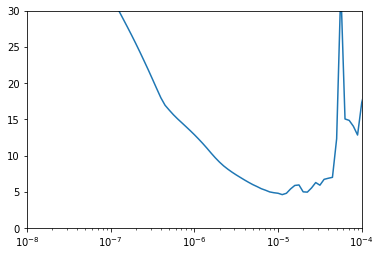

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model= tf.keras.Sequential([
                                   tf.keras.layers.Conv1D(filters= 32, 
                                                          kernel_size= 3,
                                                          strides= 1, padding= 'causal', activation='relu', input_shape= [None, 1]),
                                   tf.keras.layers.LSTM(32, return_sequences=True),
                                   tf.keras.layers.LSTM(32, return_sequences= True),
                                   tf.keras.layers.Dense(1), 
                                   tf.keras.layers.Lambda(lambda x: x*200)
])
optimizer= tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss= tf.keras.losses.Huber(),optimizer=optimizer, metrics=['mae'])
history= model.fit(dataset, epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 23ms/step - loss: 33.5999 - mae: 34.0956
Epoch 2/500
31/31 [==============================] - 1s 23ms/step - loss: 8.4929 - mae: 8.9781
Epoch 3/500
31/31 [==============================] - 1s 24ms/step - loss: 6.9030 - mae: 7.3851
Epoch 4/500
31/31 [==============================] - 1s 26ms/step - loss: 6.3056 - mae: 6.7856
Epoch 5/500
31/31 [==============================] - 1s 24ms/step - loss: 5.7221 - mae: 6.2019
Epoch 6/500
31/31 [==============================] - 1s 24ms/step - loss: 5.7311 - mae: 6.2118
Epoch 7/500
31/31 [==============================] - 1s 25ms/step - loss: 5.6260 - mae: 6.1051
Epoch 8/500
31/31 [==============================] - 1s 24ms/step - loss: 5.3659 - mae: 5.8451
Epoch 9/500
31/31 [==============================] - 1s 25ms/step - loss: 5.3749 - mae: 5.8540
Epoch 10/500
31/31 [==============================] - 1s 25ms/step - loss: 5.1568 - mae: 5.6356
Epoch 11/500
31/31 [===========================

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

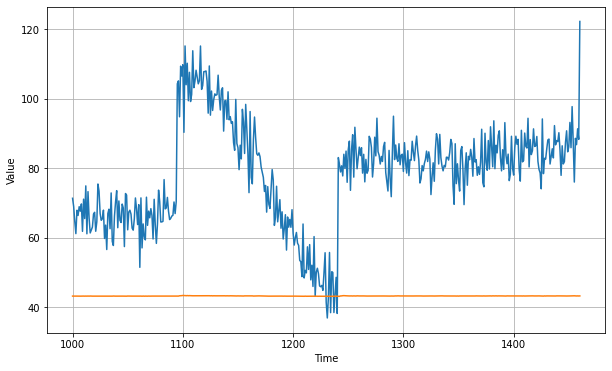

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

35.33915

<Figure size 432x288 with 0 Axes>

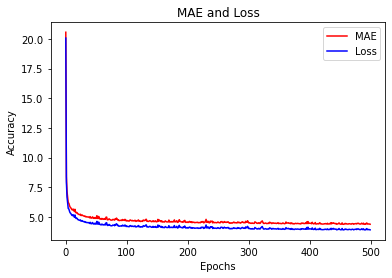

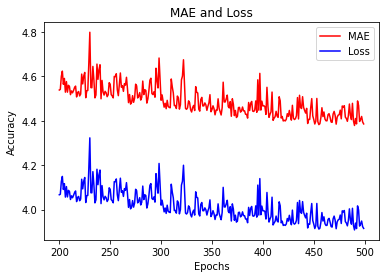

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

**Lesson 2**

In [19]:
import tensorflow as tf

In [20]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [21]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-12-20 14:35:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.214.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-12-20 14:35:29 (110 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



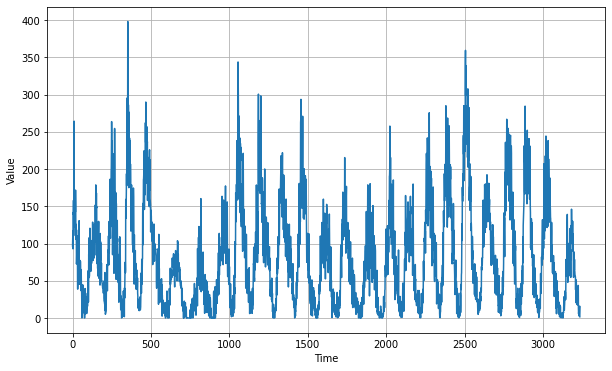

In [22]:
import csv 
time_step= []
sunspots= []

with open('/tmp/sunspots.csv') as csvfile:
  reader= csv.reader(csvfile, delimiter= ',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
series= np.array(sunspots)
time= np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

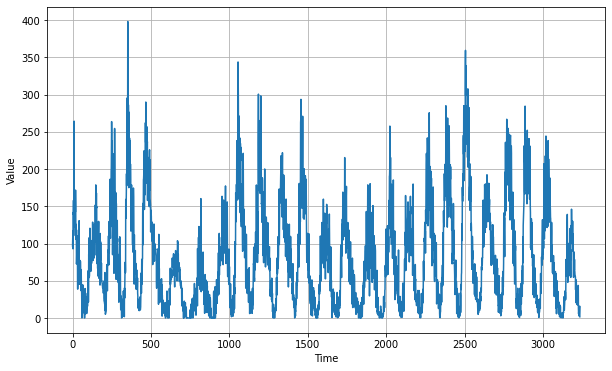

In [23]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [24]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 307ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 4s 304ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 4s 306ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 4s 306ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 4s 304ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 4s 306ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 4s 308ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 4s 306ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 4s 306ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/

(1e-08, 0.0001, 0.0, 60.0)

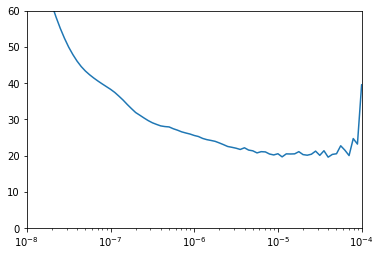

In [28]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 120ms/step - loss: 47.7137 - mae: 48.2109
Epoch 2/500
30/30 [==============================] - 4s 118ms/step - loss: 26.8720 - mae: 27.3669
Epoch 3/500
30/30 [==============================] - 4s 119ms/step - loss: 22.9778 - mae: 23.4724
Epoch 4/500
30/30 [==============================] - 4s 120ms/step - loss: 20.2820 - mae: 20.7753
Epoch 5/500
30/30 [==============================] - 4s 119ms/step - loss: 19.0068 - mae: 19.4986
Epoch 6/500
30/30 [==============================] - 4s 120ms/step - loss: 19.1465 - mae: 19.6385
Epoch 7/500
30/30 [==============================] - 4s 120ms/step - loss: 18.4978 - mae: 18.9894
Epoch 8/500
30/30 [==============================] - 4s 120ms/step - loss: 18.0319 - mae: 18.5232
Epoch 9/500
30/30 [==============================] - 4s 120ms/step - loss: 18.1642 - mae: 18.6554
Epoch 10/500
30/30 [==============================] - 4s 121ms/step - loss: 19.7740 - mae: 20.2661
Epoch 11/500
30/30 

In [30]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

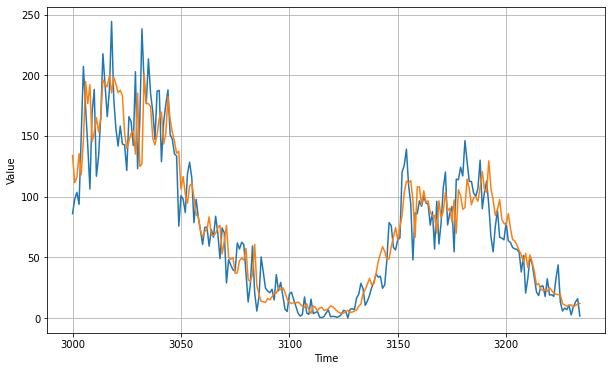

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.563733

<Figure size 432x288 with 0 Axes>

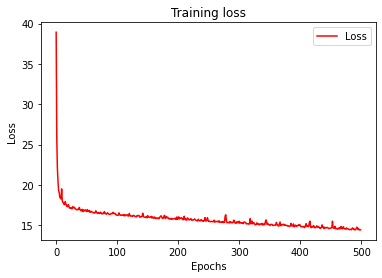

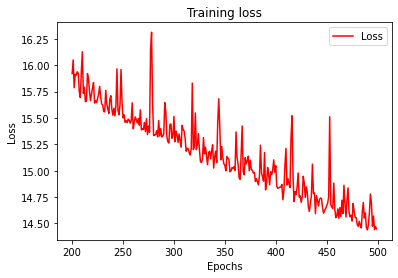

<Figure size 432x288 with 0 Axes>

In [33]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [34]:
print(rnn_forecast)

[133.86688   111.423805  115.95533   135.33765   117.97729   146.20572
 194.91243   176.58174   192.16011   145.05191   153.02274   164.96251
 153.32277   164.63734   196.19318   192.64333   190.55417   199.91469
 185.38148   198.20222   192.71736   185.60817   187.6921    183.2837
 152.36525   139.6168    145.59373   152.15611   154.51826   135.01263
 185.15196   124.83418   127.0245    201.48062   176.70314   176.69986
 174.21355   147.92514   142.54039   151.19281   164.48863   169.62912
 143.34987   151.93816   182.32211   164.04097   153.14157   145.50035
 135.74567   137.32808   106.24745   116.539894  102.26559    94.592606
 108.81598   110.74693    99.526436   85.29563    83.44363    71.62722
  66.86533    71.2244     73.087296   83.279785   68.44928    68.01071
  69.66847    74.41801    76.364395   52.788662   63.327374   76.29181
  49.932068   48.331852   49.81824    36.724575   37.29638    47.113686
  49.255337   47.69706    57.3641     31.602547   30.19172    35.825516
  60